In [3]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC

In [4]:
# Paths
train_img_dir = "./cat-with-prey-detection-20/train/images"
train_lbl_dir = "./cat-with-prey-detection-20/train/labels"
test_img_dir = "./cat-with-prey-detection-20/test/images"
test_lbl_dir = "./cat-with-prey-detection-20/test/labels"
IMAGE_SIZE = 640
# Classes (from data.yaml)
label_map = {0: "cat", 1: "prey"}


def get_image_label(lbl_path) -> str:
    """Return image-level label: 'nothing', 'cat', 'cat+prey'"""
    with open(lbl_path) as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]  # noqa: E741

    if len(lines) == 0:
        return "nothing"

    class_ids = {int(line.split()[0]) for line in lines}
    if 0 in class_ids and 1 in class_ids:
        return "cat+prey"
    if 0 in class_ids:
        return "cat"
    if 1 in class_ids:
        return "cat+prey"  # merge prey-only into cat+prey if desired
    return "nothing"


def extract_features(image):  # noqa: ANN201
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features


X, y = [], []

In [5]:
label_files = glob.glob(os.path.join(train_lbl_dir, "*.txt"))
total_files = len(label_files)

for idx, lbl_path in enumerate(label_files, start=1):
    print(f"[{idx}/{total_files}] Processing {os.path.basename(lbl_path)}")

    base = os.path.basename(lbl_path).replace(".txt", ".jpg")
    img_path = os.path.join(train_img_dir, base)
    if not os.path.exists(img_path):
        print(f"  ⚠️ Image not found for {base}")
        continue

    img = cv2.imread(img_path)
    if img is None:
        print(f"  ⚠️ Could not read image {base}")
        continue

    # Resize to standard size
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

    # Determine label from file contents
    with open(lbl_path) as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]  # noqa: E741

    if len(lines) == 0:
        label = "nothing"
    else:
        class_ids = {int(line.split()[0]) for line in lines}
        if 0 in class_ids and 1 in class_ids:
            label = "cat+prey"
        elif 0 in class_ids:
            label = "cat"
        elif 1 in class_ids:
            label = "prey"  # if you want to merge prey-only into "cat+prey", change here
        else:
            label = "nothing"  # fallback

    # Extract features for the whole image
    features = extract_features(img)
    X.append(features)
    y.append(label)

print(f"\n✅ Processed {len(X)} images.")
print(f"Label distribution: { {lbl: y.count(lbl) for lbl in set(y)} }")

[1/2952] Processing 152124resized_frame_29_bmp.rf.225887470424232e1117646c155d1ffc.txt
[2/2952] Processing 152124resized_frame_29_bmp.rf.8349fdda67255bf783b09665147ceec9.txt
[3/2952] Processing 152124resized_frame_29_bmp.rf.f228dfa27350efd99a29c944ec646c37.txt
[4/2952] Processing 152124resized_frame_34_bmp.rf.a524e46079e198b7d9a64ce7f5452c35.txt
[5/2952] Processing 152124resized_frame_34_bmp.rf.bb3efef63fdcb2571998d2957a2669be.txt
[6/2952] Processing 152124resized_frame_34_bmp.rf.d00dbb32d4cb039345d91dda7f5dc79b.txt
[7/2952] Processing 152124resized_frame_35_bmp.rf.0a32671d68c8e46a030b4a679206950a.txt
[8/2952] Processing 152124resized_frame_35_bmp.rf.331ac4335fbfc2406291fbc4773d02c9.txt
[9/2952] Processing 152124resized_frame_35_bmp.rf.e43c6b0a830e22d96b1de1ec3b200b4c.txt
[10/2952] Processing 152124resized_frame_36_bmp.rf.08b4b97921943c10e9429f31825acc96.txt
[11/2952] Processing 152124resized_frame_36_bmp.rf.55032e17836a424038b42056e31c930f.txt
[12/2952] Processing 152124resized_frame_

In [6]:
print(f"Extracted {len(X)} samples")

Extracted 2952 samples


In [7]:
X = np.array(X).astype(np.float32)  # this should be more efficient

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [ ]:
models = {
    "LinearSVC": LinearSVC(max_iter=5000, dual=False),
    "SVC_rbf": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200),
    "LogisticRegression": LogisticRegression(max_iter=5000, n_jobs=-1),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
}

In [ ]:
from joblib import Parallel, delayed
from sklearn.base import clone


def _fit(name, model, X, y):  # noqa: ANN202, N803
    print(f"Training {name}...")
    try:
        fitted = model.fit(X, y)
        print(f"{name} done.")
        return name, fitted
    except Exception as e:
        print(f"{name} failed: {e}")
        return name, None


# Train models in parallel (one process per job). Clone to ensure fresh estimator per worker.
results = Parallel(n_jobs=-1, prefer="processes")(
    delayed(_fit)(name, clone(model), X, y_enc) for name, model in models.items()
)

trained_models = {name: model for name, model in results if model is not None}

KeyboardInterrupt: 

In [ ]:
from joblib import dump

for model in trained_models:
    # save trained models
    dump(trained_models[model], f"./models/{model}.joblib")

In [9]:
# load models
from joblib import load

trained_models = {}
for model_file in glob.glob("./models/*.joblib"):
    model_name = os.path.basename(model_file).replace(".joblib", "")
    trained_models[model_name] = load(model_file)

In [10]:
# extract the test set features and labels
X_test, y_test = [], []
label_files = glob.glob(os.path.join(test_lbl_dir, "*.txt"))
for idx, lbl_path in enumerate(label_files, 1):
    base = os.path.basename(lbl_path).replace(".txt", ".jpg")
    img_path = os.path.join(test_img_dir, base)
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # resize to standard size
    features = extract_features(img)
    X_test.append(features)
    y_test.append(get_image_label(lbl_path))

X_test = np.array(X_test).astype(np.float32)
y_test_enc = le.fit_transform(y_test)

In [11]:
y_test_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [13]:
for model in trained_models.values():
    y_pred_test_enc = model.predict(X_test)
    print(f"Results for model: {model.__class__.__name__}")
    print(classification_report(y_test_enc, y_pred_test_enc, zero_division=0))

Results for model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.96      0.51      0.66       175
           1       0.35      0.56      0.43        82
           2       0.00      0.00      0.00         0

    accuracy                           0.53       257
   macro avg       0.44      0.36      0.37       257
weighted avg       0.76      0.53      0.59       257

Results for model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.94      0.36      0.52       175
           1       0.27      0.48      0.35        82
           2       0.00      0.00      0.00         0

    accuracy                           0.40       257
   macro avg       0.40      0.28      0.29       257
weighted avg       0.73      0.40      0.46       257

Results for model: LinearSVC
              precision    recall  f1-score   support

           0       0.97      0.54      0.70       175
           1  

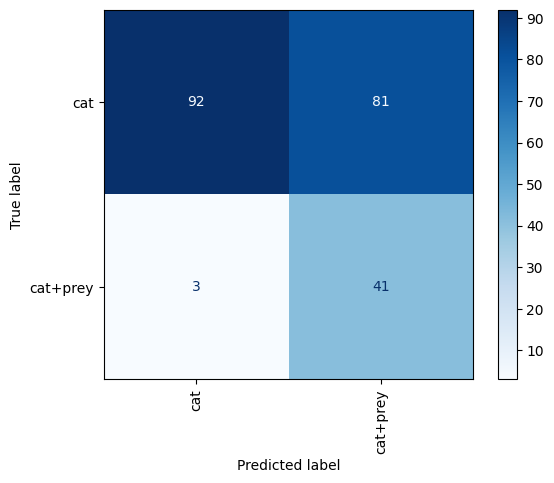

In [14]:
# print confusion matrix and classification report
classes = le.classes_
cm = confusion_matrix(
    y_test_enc,
    y_pred_test_enc,
    labels=le.transform(classes),  # ensure all 3 classes are counted
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()